# BYO Planner

This example shows you how to **Bring Your Own** (BYO) planner to work with the `a2rl.Simulator` API.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import my_nb_path  # isort: skip
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import Markdown
from tqdm.autonotebook import tqdm

import a2rl as wi
from a2rl.nbtools import print  # Enable color outputs when rich is installed.

import seaborn as sns  # isort: skip  # After a2rl, sns's suprious deprecation warnings are gone.

# Misc. settings
plt.rcParams["figure.figsize"] = [10, 6]
RAN_SEED = 42
random.seed(RAN_SEED)
np.random.seed(RAN_SEED)
_ = torch.manual_seed(RAN_SEED)

/tmp/ipykernel_3421/2758631463.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Load Dataset

In [2]:
BLOCK_SIZE_ROW = 2  # block_size (measured by # of rows) as the context to train GPT
wi_df = wi.read_csv_dataset(wi.sample_dataset_path("chiller"))
wi_df.add_value()

# Speed up training for demo purpose
wi_df = wi_df.iloc[:1000]

# Instantiate a tokenier given the selected dataset.
tokenizer = wi.AutoTokenizer(wi_df, block_size_row=BLOCK_SIZE_ROW)
tokenizer.df.head(2)

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


condenser_inlet_temp  evaporator_heat_load_rt staging   
0                  29.5                    455.4       1  \
1                  30.2                    913.1       0   

   system_power_consumption        value  
0                     756.4  1007.294795  
1                     959.3   780.987943

In [3]:
tokenizer.df_tokenized.head(2)

condenser_inlet_temp  evaporator_heat_load_rt  staging   
0                    26                       45      344  \
1                    33                      104      343   

   system_power_consumption  value  
0                       173    300  
1                       213    261

## Create the Simulator

### Load or Train the GPT model

In [4]:
model_dir = "model-byo"
config = None  # Default training configuration

################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    config = {
        "train_config": {
            "epochs": 1,
            "batch_size": 512,
            "embedding_dim": 512,
            "gpt_n_layer": 1,
            "gpt_n_head": 1,
            "learning_rate": 6e-4,
            "num_workers": 0,
            "lr_decay": True,
        }
    }

    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Use only 1 epoch. Results may differ."
        )
    )
################################################################################

builder = wi.GPTBuilder(tokenizer, model_dir, config)

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Use only 1 epoch. Results may differ.

Start GPT model training.

Default hyperparam is located at `src/a2rl/config.yaml`

In [5]:
# %%time
model_fname = os.path.join(model_dir, builder.model_name)
if os.path.exists(model_fname):
    print(f"Will load the GPT model from {model_fname}")
    builder.load_model()
else:
    print("Training the GPT model")
    builder.fit()

Training the GPT model


2023-05-22 10:07:30.931 | INFO     | a2rl.simulator:fit:753 - {'epochs': 1, 'batch_size': 512, 'embedding_dim': 512, 'gpt_n_layer': 1, 'gpt_n_head': 1, 'learning_rate': 0.0006, 'num_workers': 0, 'lr_decay': True}


  0%|          | 0/10 [00:00<?, ?it/s]

2023-05-22 10:07:36.035 | INFO     | a2rl.simulator:fit:787 - Training time in mins: 0.084


### Instantiate the Simulator Instance
To create a simulator, we need pass in the tokenzier and the GPT model wrapped inside `a2rl.Simulator.GPTBuilder`

In [6]:
simulator = wi.Simulator(tokenizer, builder.model)

## Build Your Own Planner

Set parameters for planners to run

In [7]:
horizon = 20  # set the planning horizon to 20 steps
nb_runs = 5
step_size = tokenizer.state_dim + tokenizer.action_dim + tokenizer.reward_dim
################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    nb_runs = 2

    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Use less samples. Results may differ."
        )
    )
################################################################################

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Use less samples. Results may differ.

## Define three planners

Here we define three planner classes as examples to illustrate how to Bring Your Own planner to work with the `A2RL` simulator.
<!-- We will add more planners (e.g. `BeamSearchPlanner`, etc.) as needed as per your feedback. -->

In [8]:
from abc import ABC
from typing import Dict, List, Optional, Tuple

import numpy as np
from tqdm import tqdm

import a2rl
from a2rl import Simulator


class A2RLPLanner(ABC):
    def __init__(
        self,
        simulator: Simulator,
    ) -> None:
        self.simulator = simulator
        self.tokenizer = simulator.tokenizer
        self.block_size = self.tokenizer.block_size
        self.action_cols = self.tokenizer.action_columns
        self.nb_actions = len(self.tokenizer.df_tokenized[self.action_cols[0]].unique())

    def rollout(self, horizon: int = 20, nb_runs: int = 3) -> List[np.array]:
        """
        Return:
            the first element of the list is a [nb_runs, horizon] array
                with immeidate cost/reward for run M (0 <= M < nb_runs), step N (0 <= N < horizon)
            the second element of the list is a [nb_runs, horizon] array
                with accumulative cost/reward for run M (0 <= M < nb_runs), step N (0 <= N < horizon)
        """
        raise NotImplementedError("A2RLPLanner needs to be subclassed")


class BehaviourClonePlanner(A2RLPLanner):
    """
    we use the `a2rl.Simulator.sample` API to obtain some random actions.
    By "random", we mean the actions (behaviour) are sampled from the probability distribution
    learned by the GPT model from the CSV dataset.
    It is expected these actions are similar to actions reflected in the data, hence the "clone" part.
    We then apply that random actions to rollout the next step.
    We do this Rollout for each step throughout the entire trajectory.
    """

    def __init__(self, simulator: Simulator) -> None:
        super().__init__(simulator)

    def _get_valid_action_indices(self, batch_size, nb_total_actions):
        """
        Each run or context in a batch corresponds to (nb_total_actions // batch_size) actions
        e.g. if `contexts` has 2 runs, calling simulator.sample(contexts, max_size=3) will
        return 6 actions, each run/context has 3 actions, with the first 3 stacked atop the last 3.

        Now calling lookahead will produce 2 * 6 = 12 context-action pairs (cartesian products).
        However, only the first three ([0, 1, 2]) and the last three pairs ([9, 10, 11]) are valid pairs,
        i.e. pairs where a context matches its own sampled acitons.

        This function returns indices for all valid pairs.
        """
        if nb_total_actions % batch_size != 0:
            raise Exception("call simulator.sample() first")
        act_per_ctx = nb_total_actions // batch_size
        indices = []
        # actions_per_context = nb_total_actions // batch_size
        for i in range(batch_size):
            start = (i * batch_size + i) * act_per_ctx
            end = start + act_per_ctx
            indices.append((start, end))
        return indices

    def rollout(self, horizon: int = 20, nb_runs: int = 3) -> List[np.array]:
        """
        rollout trajectories using actions learned from the past data
        """
        accum_cost_list = []  # shape: [nb_horizon, nb_runs]
        non_accum_cost_list = []  # shape: [nb_horizon, nb_runs]
        batch_size = nb_runs
        custom_context = self.tokenizer.df_tokenized.iloc[0, : self.tokenizer.state_dim].values
        per_ctx_max_size = 1
        # obtain a valid "random" action
        for i in tqdm(range(horizon)):
            if custom_context.ndim == 1:
                batch_custom_context = np.tile(custom_context, (batch_size, 1))
            else:
                batch_custom_context = custom_context

            if batch_custom_context.shape[1] > self.block_size:
                truncated_custom_context = batch_custom_context[:, -self.block_size :]
            else:
                truncated_custom_context = batch_custom_context

            recommendation_df = self.simulator.sample(
                truncated_custom_context, max_size=per_ctx_max_size, as_token=True
            )
            my_actions = recommendation_df[self.action_cols].values
            reward, next_states = self.simulator.lookahead(batch_custom_context, my_actions)

            valid_indices = self._get_valid_action_indices(batch_size, my_actions.shape[0])
            reward_sl, next_states_sl = [], []
            for sti, edi in valid_indices:
                reward_sl.append(reward[sti:edi])
                next_states_sl.append(next_states[sti:edi])
            # pick the reward and states as per their matching actions wrt. contexts
            reward = np.vstack(reward_sl)
            next_states = np.vstack(next_states_sl)

            samples = np.hstack([my_actions, reward, next_states])

            df_ars = a2rl.WiDataFrame(
                samples,
                **self.tokenizer.df_tokenized.sar_d,
                columns=[
                    *self.tokenizer.df_tokenized.actions,
                    *self.tokenizer.df_tokenized.rewards,
                    *self.tokenizer.df_tokenized.states,
                ],
            )
            df_sar = df_ars[df_ars.sar]
            df_sar = self.tokenizer.field_tokenizer.inverse_transform(df_sar)
            immediate_cost = df_sar[self.tokenizer.df_tokenized.rewards[:-1]].values
            custom_context = np.hstack([batch_custom_context, samples])
            non_accum_cost_list.append(immediate_cost.flatten().tolist())

        accum_cost_list = np.array(non_accum_cost_list)
        non_accum_cost_list = np.array(non_accum_cost_list)
        for i in range(1, len(non_accum_cost_list)):
            accum_cost_list[i, :] = accum_cost_list[i - 1, :] + non_accum_cost_list[i, :]

        accum_cost_list = accum_cost_list.transpose()
        non_accum_cost_list = non_accum_cost_list.transpose()
        return [non_accum_cost_list, accum_cost_list]


class QPlanner(A2RLPLanner):
    """
    we use the `a2rl.Simulator.get_valid_actions` to obtain all the valid actions.
    Then we use `a2rl.Simulator.lookahead` to "explore" each action by obtaining
    both immediate reward and reward-to-go.
    Next, we choose the action that has the highest / lowest sum_reward (immediate_reward + reward-to-go),
    and take that action to the next step. We do this Rollout for the entire trajectory
    """

    def __init__(self, simulator: Simulator, objective: str = "min") -> None:
        super().__init__(simulator)
        if objective.lower() not in ["min", "max"]:
            raise ValueError("objective must be either min or max")
        if "min" == objective:
            self.obj_op = np.argmin
        else:
            self.obj_op = np.argmax

    def rollout(self, horizon: int = 20, nb_runs: int = 3) -> List[np.array]:
        q_accum_cost_list = []
        q_non_accum_cost_list = []

        batch_size = nb_runs
        custom_context = self.tokenizer.df_tokenized.iloc[0, : self.tokenizer.state_dim].values

        for i in tqdm(range(horizon)):
            if custom_context.ndim == 1:
                batch_custom_context = np.tile(custom_context, (batch_size, 1))
            else:
                batch_custom_context = custom_context

            if batch_custom_context.shape[1] > self.block_size:
                truncated_custom_context = batch_custom_context[:, -self.block_size :]
            else:
                truncated_custom_context = batch_custom_context

            all_valid_actions = self.simulator.get_valid_actions(
                truncated_custom_context[0], max_size=self.nb_actions
            ).values

            reward, next_states = self.simulator.lookahead(batch_custom_context, all_valid_actions)

            tiled_actions = np.tile(all_valid_actions, (batch_size, 1))
            samples = np.hstack([tiled_actions, reward, next_states])
            df_ars = a2rl.WiDataFrame(
                samples,
                **self.tokenizer.df_tokenized.sar_d,
                columns=[
                    *self.tokenizer.df_tokenized.actions,
                    *self.tokenizer.df_tokenized.rewards,
                    *self.tokenizer.df_tokenized.states,
                ],
            )

            df_sar = df_ars[df_ars.sar]
            df_sar = self.tokenizer.field_tokenizer.inverse_transform(
                df_sar
            )  # need untokenized (original) reward values
            reward = df_sar[self.tokenizer.df_tokenized.rewards].values

            both_cost = reward.sum(axis=1)  # sum of immediate cost + cost_to_go
            both_cost = both_cost.reshape([batch_size, -1])
            action_idx = self.obj_op(both_cost, axis=1)  # for each run gets its min-cost index
            rs_reward = reward.reshape(
                [batch_size, -1, self.tokenizer.reward_dim]
            )  # [nb_runs, nb_actions, reward_dim]
            # pick the reward as per the min-cost action
            sel_reward = np.array([data[action] for data, action in zip(rs_reward, action_idx)])
            immediate_cost = sel_reward[:, 0]
            q_non_accum_cost_list.append(immediate_cost.flatten().tolist())

            # use the tokenized dataframe to select the new context as per the min-cost action
            df_ars_reshape = df_ars.values.reshape([batch_size, -1, len(df_ars.columns)])
            new_context = np.array(
                [data[action] for idx, (data, action) in enumerate(zip(df_ars_reshape, action_idx))]
            )
            custom_context = np.hstack([batch_custom_context, new_context])

        q_accum_cost_list = np.array(q_non_accum_cost_list)
        q_non_accum_cost_list = np.array(q_non_accum_cost_list)
        for i in range(1, len(q_non_accum_cost_list)):
            q_accum_cost_list[i, :] = q_accum_cost_list[i - 1, :] + q_non_accum_cost_list[i, :]

        q_accum_cost_list = q_accum_cost_list.transpose()
        q_non_accum_cost_list = q_non_accum_cost_list.transpose()
        return [q_non_accum_cost_list, q_accum_cost_list]


class BeamSearchQPlanner(A2RLPLanner):
    """
    This planner has similar logic to the QPlanner, only it uses `a2rl.Simulator.beam_search_n_steps`
    to obtain all the actions and rewards in one go.
    The actions are still chosen with the highest / lowest sum_reward (immediate_reward + reward-to-go),
    and take that action to the next step.
    """

    def __init__(
        self, simulator: Simulator, beam_width: int, beam_random: bool, objective: str = "min"
    ) -> None:
        super().__init__(simulator)

        self.beam_width = beam_width
        self.beam_random = beam_random

        if objective.lower() not in ["min", "max"]:
            raise ValueError("objective must be either min or max")
        if "min" == objective:
            self.obj_op = np.argmin
        else:
            self.obj_op = np.argmax

    def rollout(self, horizon: int = 20, nb_runs: int = 3) -> List[np.array]:
        if nb_runs != 1:
            print(
                "WARN: multiple runs in beam search is implemented as a loop and not vectorized and performance may be slow"
            )

        if nb_runs != 1 and not self.beam_random:
            raise ValueError("'beam_random' should be True when using multiple runs")

        dataframe_per_run = []
        non_accum_rewards_list = []
        accum_rewards_list = []

        initial_context = self.tokenizer.df_tokenized.iloc[0, : self.tokenizer.state_dim].values

        for i_run in range(nb_runs):
            non_accum_rewards = []

            if initial_context.ndim != 1:
                raise NotImplementedError("batching not implemented")

            # Overwite some tokens if you need. See below "Create and run the BeamSearchQPlanner" for details
            overwrite_valid_tokens = {}

            # Generate A+R+S tokens each time
            context = initial_context
            n_steps = (
                self.tokenizer.action_dim + self.tokenizer.reward_dim + self.tokenizer.state_dim
            )

            for i in tqdm(range(horizon)):
                new_context, accum_logprobs = self.simulator.beam_search_n_steps(
                    seq=context,
                    n_steps=n_steps,
                    beam_width=self.beam_width,
                    randomness=self.beam_random,
                    overwrite_valid_tokens=overwrite_valid_tokens,
                    return_logprobs=True,
                )

                ars_tokens = new_context[:, len(context) :]
                df_ars = wi.WiDataFrame(
                    ars_tokens,
                    **self.tokenizer.df_tokenized.sar_d,
                    columns=[
                        *self.tokenizer.action_columns,
                        *self.tokenizer.reward_columns,
                        *self.tokenizer.state_columns,
                    ],
                )

                df_sar = df_ars[df_ars.sar]
                df_sar = self.tokenizer.field_tokenizer.inverse_transform(df_sar)

                rewards = df_sar[self.tokenizer.reward_columns].values
                best_idx = self.obj_op(rewards.sum(axis=1))
                non_accum_rewards.append(rewards[best_idx, 0])

                context = new_context[best_idx]

            # Uncomment the following if you want to record a dataframe per run
            # widf_searched = wi.WiDataFrame(
            #     context[len(initial_context) :].reshape(horizon, -1),
            #     **self.tokenizer.df_tokenized.sar_d,
            #     columns=[
            #         *self.tokenizer.df_tokenized.actions,
            #         *self.tokenizer.df_tokenized.rewards,
            #         *self.tokenizer.df_tokenized.states,
            #     ],
            # )
            # widf_searched = widf_searched[widf_searched.sar]
            # widf_searched = self.tokenizer.field_tokenizer.inverse_transform(widf_searched)
            # widf_searched["nb_run"] = i_run
            # widf_searched["timestep"] = range(1, len(widf_searched) + 1)
            # dataframe_per_run.append(widf_searched)

            non_accum_rewards = np.array(non_accum_rewards)
            accum_rewards = np.cumsum(non_accum_rewards, axis=0)

            non_accum_rewards_list.append(non_accum_rewards)
            accum_rewards_list.append(accum_rewards)

        non_accum_rewards_list = np.array(non_accum_rewards_list)
        accum_rewards_list = np.array(accum_rewards_list)

        return [non_accum_rewards_list, accum_rewards_list]

### Create and run the `BehaviourClonePlanner` 

In [9]:
bcp = BehaviourClonePlanner(simulator)
non_accum_cost_list, accum_cost_list = bcp.rollout(horizon, nb_runs)

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [00:00<00:00, 25.13it/s]

 30%|███       | 6/20 [00:00<00:00, 24.08it/s]

 45%|████▌     | 9/20 [00:00<00:00, 23.89it/s]

 60%|██████    | 12/20 [00:00<00:00, 23.74it/s]

 75%|███████▌  | 15/20 [00:00<00:00, 23.87it/s]

 90%|█████████ | 18/20 [00:00<00:00, 23.90it/s]

100%|██████████| 20/20 [00:00<00:00, 23.93it/s]

### Create and run the `QPlanner` 

In [10]:
qp = QPlanner(simulator)
q_non_accum_cost_list, q_accum_cost_list = qp.rollout(horizon, nb_runs)

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:01, 14.66it/s]

 20%|██        | 4/20 [00:00<00:01, 13.96it/s]

 30%|███       | 6/20 [00:00<00:01, 13.74it/s]

 40%|████      | 8/20 [00:00<00:00, 13.63it/s]

 50%|█████     | 10/20 [00:00<00:00, 13.63it/s]

 60%|██████    | 12/20 [00:00<00:00, 13.68it/s]

 70%|███████   | 14/20 [00:01<00:00, 13.49it/s]

 80%|████████  | 16/20 [00:01<00:00, 13.46it/s]

 90%|█████████ | 18/20 [00:01<00:00, 13.21it/s]

100%|██████████| 20/20 [00:01<00:00, 13.26it/s]

100%|██████████| 20/20 [00:01<00:00, 13.48it/s]

### Create and run the `BeamSearchQPlanner`

In [11]:
bsqp = BeamSearchQPlanner(simulator, beam_width=8, beam_random=True)
bsq_non_accum_cost_list, bsq_accum_cost_list = bsqp.rollout(horizon, nb_runs)

WARN: multiple runs in beam search is implemented as a loop and not vectorized and performance may be slow


  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:00<00:00, 40.50it/s]

 50%|█████     | 10/20 [00:00<00:00, 39.08it/s]

 70%|███████   | 14/20 [00:00<00:00, 38.85it/s]

 90%|█████████ | 18/20 [00:00<00:00, 38.60it/s]

100%|██████████| 20/20 [00:00<00:00, 38.73it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:00<00:00, 40.80it/s]

 50%|█████     | 10/20 [00:00<00:00, 39.20it/s]

 70%|███████   | 14/20 [00:00<00:00, 38.85it/s]

 90%|█████████ | 18/20 [00:00<00:00, 38.61it/s]

100%|██████████| 20/20 [00:00<00:00, 38.71it/s]

#### How to use the `overwrite_valid_tokens` argument in Beam Search

Beam Search has another feature to constrain the tokens sampled in a column, via the
`overwrite_valid_tokens` argument in `beam_search_n_steps`. This feature is useful if
additional constraint needs to imposed during inference that is not present in the
training data.

For example:
- Column "Action_1" contains 5 valid actions: **[101, 102, 103, 104, 105]**. During
training, all 5 actions are present in the training data, so the simulator learnt to use
all 5 actions.
- However, during inference, due to external constraint, only 3 actions are valid:
**[101, 103, 105]**, and we still want to see which action is the best, so we use the
`overwrite_valid_tokens` argument.
```python
overwrite_valid_tokens = {"Action_1": [101, 103, 105]}
```
- If there's another column with similar constraint:
```python
overwrite_valid_tokens = {"Action_1": [101, 103, 105], "State_3": [203, 204]}
```
- A special case is if you want to fix a column during sampling:
```python
overwrite_valid_tokens = {"Action_1": [101]}
```

Depending on where you create and use this argument, you can dynamically constrain part
of the rollout:
```python
def rollout():
    for timestep in range(horizon):
        if timestep < 10:
            overwrite_valid_tokens = {"Action_1": [101, 103, 105]}
        else:
            overwrite_valid_tokens = None  # no overwriting

        simulator.beam_search_n_steps(...)
```
or apply during the entire rollout:
```python
def rollout():
    overwrite_valid_tokens = {"Action_1": [101, 103, 105]}
    for timestep in range(horizon):
        simulator.beam_search_n_steps(...)
```

This overwriting is applied *before* said column is sampled. So that column and all
subsequent columns are affected by the constraint.

This is also useful if there's a special token such as `<EOS>` which is present in the
training data but should not appear in inference.

### Compare the costs (`system_power_consumption`) between three planners

On average (in the sense of **expected** outcome), the `Q-value Maximisation` planner (`QPlanner` for short) produces relatively lower `system_power_consumption`. However, the `Bahaviour Clone` actions may occasionally perform equally well. This is due to the non-deterministic nature of both the *Simulator* when performing `simulator.lookahead()` and the randomness associated with `simulator.sample()`. Moreover, the GPT model associated with the *Simulator* in this example was not trained sufficiently in terms of both the number of epochs and the size of the training data.

The beam search planner should demonstrate a performance between behaviour cloning and Q-planner, since the idea of beam search is to create a better simulation and ask the planner not to be over-confident about the results.

In [12]:
step_list = []
policy_list = []
acc_cost = []
inst_cost = []

In [13]:
for i in range(nb_runs):
    for j in range(horizon):
        step_list.append(j)
        acc_cost.append(accum_cost_list[i][j])
        inst_cost.append(non_accum_cost_list[i][j])
        policy_list.append("behaviour")

        step_list.append(j)
        acc_cost.append(q_accum_cost_list[i][j])
        inst_cost.append(q_non_accum_cost_list[i][j])
        policy_list.append("q-value")

        step_list.append(j)
        acc_cost.append(bsq_accum_cost_list[i][j])
        inst_cost.append(bsq_non_accum_cost_list[i][j])
        policy_list.append("beam-search")

In [14]:
df_result = pd.DataFrame(
    {
        "step": step_list,
        "acc_cost": acc_cost,
        "step_cost": inst_cost,
        "policy": policy_list,
    }
)

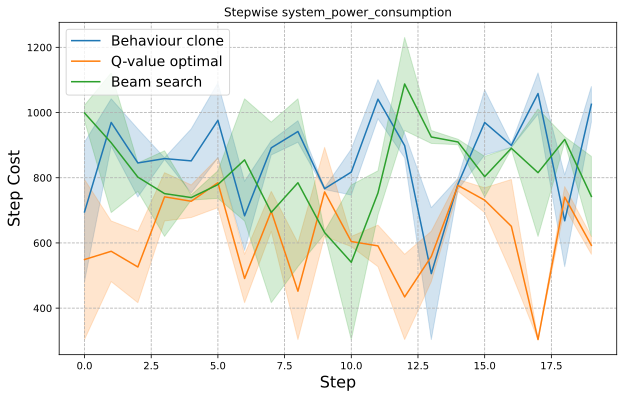

In [15]:
sns.lineplot(
    data=df_result[df_result.policy == "behaviour"],
    x="step",
    y="step_cost",
    label="Behaviour clone",
)
sns.lineplot(
    data=df_result[df_result.policy == "q-value"], x="step", y="step_cost", label="Q-value optimal"
)
sns.lineplot(
    data=df_result[df_result.policy == "beam-search"], x="step", y="step_cost", label="Beam search"
)
plt.legend(fontsize=14)
plt.grid(ls="--")
plt.xlabel("Step", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.ylabel("Step Cost", fontsize=16)
_ = plt.title("Stepwise system_power_consumption")

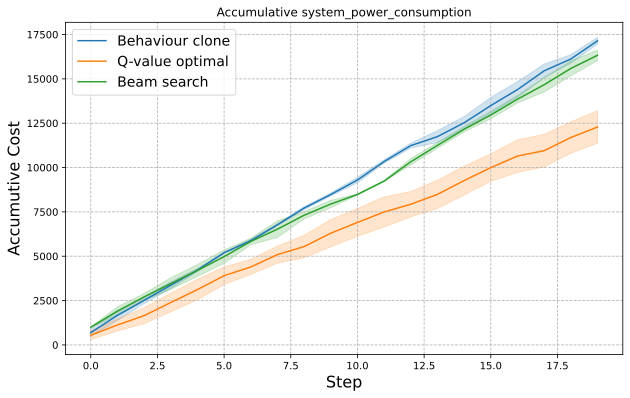

In [16]:
data1 = df_result[(df_result.policy == "behaviour")]
data2 = df_result[(df_result.policy == "q-value")]
data3 = df_result[(df_result.policy == "beam-search")]

sns.lineplot(data=data1, x="step", y="acc_cost", label="Behaviour clone")
sns.lineplot(data=data2, x="step", y="acc_cost", label="Q-value optimal")
sns.lineplot(data=data3, x="step", y="acc_cost", label="Beam search")
plt.legend(fontsize=14)
plt.grid(ls="--")
plt.xlabel("Step", fontsize=16)
plt.ylabel("Accumutive Cost", fontsize=16)
_ = plt.title("Accumulative system_power_consumption")